In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML/Fraud Detection/creditcard.csv')

In [6]:
print(data.columns)
data


Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [7]:
print(data.shape)
print(data.describe())

(284807, 31)
                Time            V1  ...         Amount          Class
count  284807.000000  2.848070e+05  ...  284807.000000  284807.000000
mean    94813.859575  3.919560e-15  ...      88.349619       0.001727
std     47488.145955  1.958696e+00  ...     250.120109       0.041527
min         0.000000 -5.640751e+01  ...       0.000000       0.000000
25%     54201.500000 -9.203734e-01  ...       5.600000       0.000000
50%     84692.000000  1.810880e-02  ...      22.000000       0.000000
75%    139320.500000  1.315642e+00  ...      77.165000       0.000000
max    172792.000000  2.454930e+00  ...   25691.160000       1.000000

[8 rows x 31 columns]


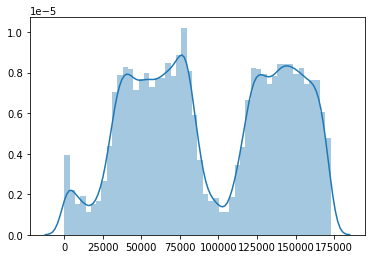

In [8]:
time = data['Time'].values
sns.distplot(time)

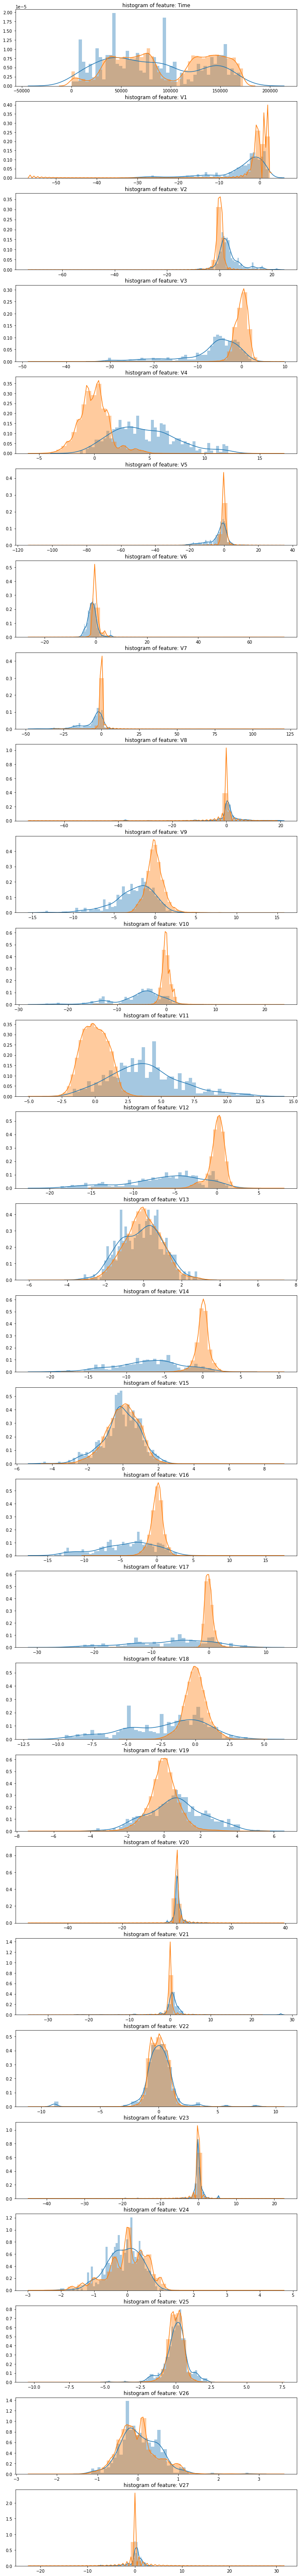

In [9]:
from matplotlib import gridspec
# distribution of anomalous features
features = data.iloc[:,0:28].columns

plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, c in enumerate(data[features]):
    ax = plt.subplot(gs[i])
    sns.distplot(data[c][data.Class == 1], bins=50)
    sns.distplot(data[c][data.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(c))
plt.show()

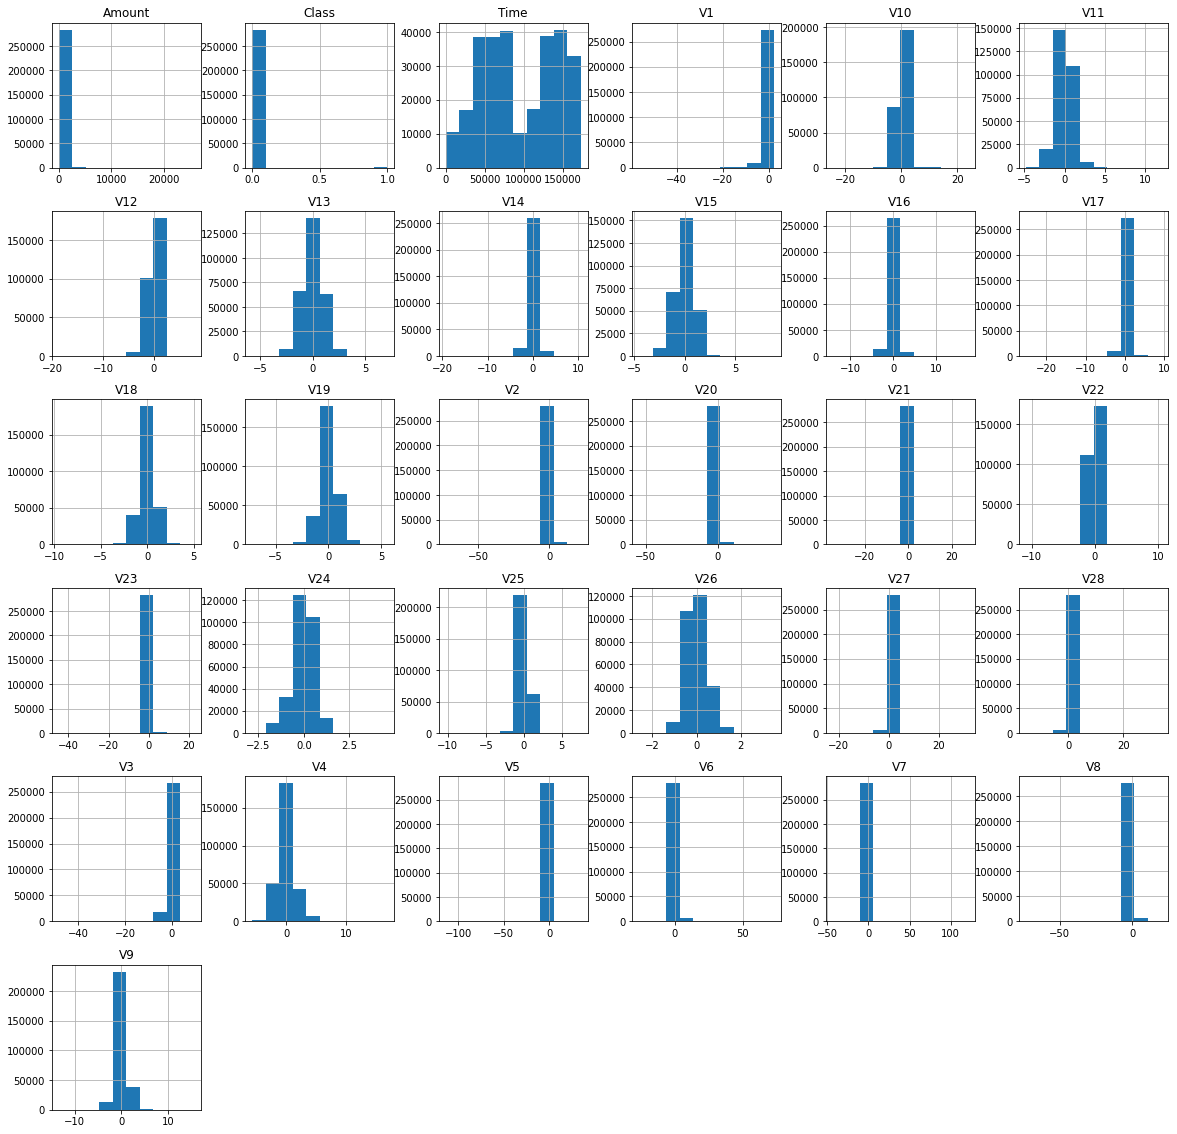

In [10]:
data.hist(figsize = (20, 20))
plt.show()

In [12]:
Fraud = data[data['Class'] == 1]
Valid = data[data['Class'] == 0]

outlier_fraction = len(Fraud)/float(len(Valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(data[data['Class'] == 1])))
print('Valid Transactions: {}'.format(len(data[data['Class'] == 0])))

0.0017304750013189597
Fraud Cases: 492
Valid Transactions: 284315


In [13]:
print("Amount details of fradulent transacation")
Fraud.Amount.describe()

Amount details of fradulent transacation


count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [14]:
print("Amount details of valid transaction")
Valid.Amount.describe()

Amount details of valid transaction


count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

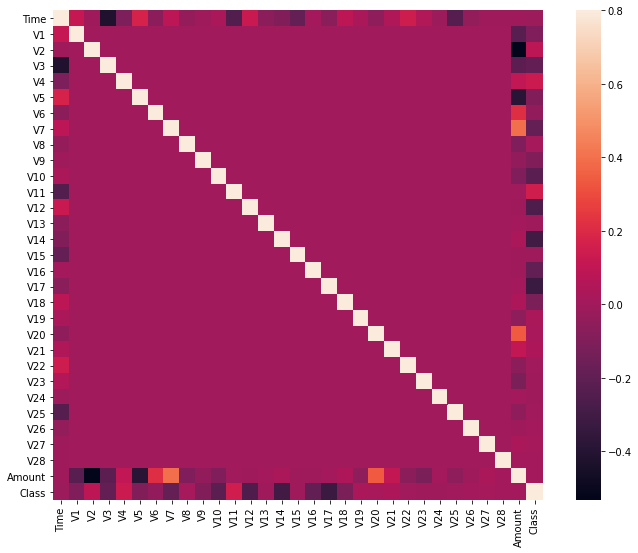

In [15]:
corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

Now let's try ML models:

In [16]:
#seperating the X and the Y from the dataset
X=data.drop(['Class'], axis=1)
Y=data["Class"]
print(X.shape)
print(Y.shape)
#getting just the values for the sake of processing (its a numpy array with no columns)
X_data=X.values
Y_data=Y.values

(284807, 30)
(284807,)


In [0]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size = 0.2, random_state = 42)

Let's start with Isolation Forest

Good explanation of Isolation Forest in Fraud Detection can be found here: https://www.youtube.com/watch?v=5p8B2Ikcw-k


In [0]:
#Building another model/classifier ISOLATION FOREST
from sklearn.ensemble import IsolationForest
ifc=IsolationForest(max_samples=len(X_train),
                    contamination=outlier_fraction,random_state=1)
ifc.fit(X_train)
scores_pred = ifc.decision_function(X_train)
y_pred = ifc.predict(X_test)

In [26]:
sum(y_pred)

56786

In [27]:
# Reshape the prediction values to 0 for valid, 1 for fraud. 
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

n_errors = (y_pred != Y_test).sum()
#evaluation of the model
#printing every score of the classifier
#scoring in any thing
from sklearn.metrics import classification_report, accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import confusion_matrix
n_outliers = len(Fraud)
print("the Model used is {}".format("Isolation Forest"))
acc= accuracy_score(Y_test,y_pred)
print("The accuracy is  {}".format(acc))
prec= precision_score(Y_test,y_pred)
print("The precision is {}".format(prec))
rec= recall_score(Y_test,y_pred)
print("The recall is {}".format(rec))
f1= f1_score(Y_test,y_pred)
print("The F1-Score is {}".format(f1))
MCC=matthews_corrcoef(Y_test,y_pred)
print("The Matthews correlation coefficient is{}".format(MCC))


the Model used is Isolation Forest
The accuracy is  0.9978933323970366
The precision is 0.375
The recall is 0.336734693877551
The F1-Score is 0.3548387096774193
The Matthews correlation coefficient is0.3543008067850027


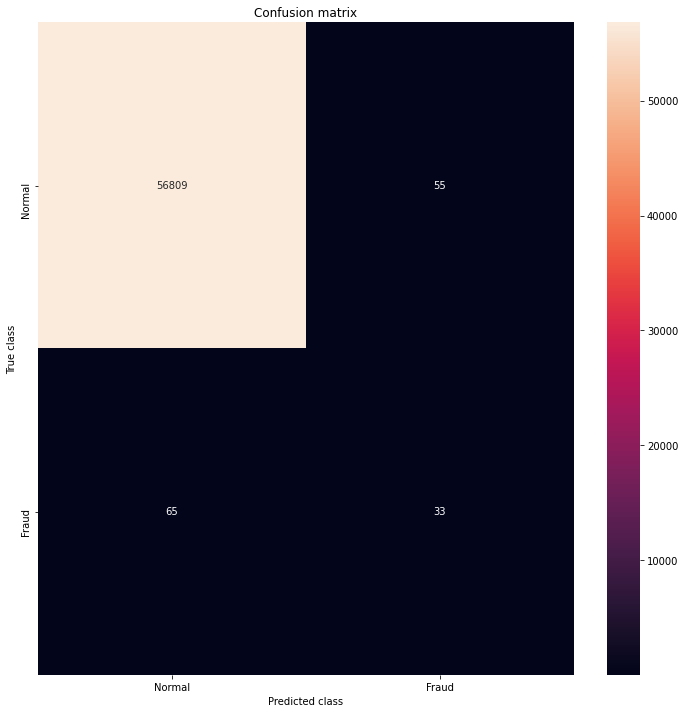

Isolation Forest: 120
0.9978933323970366
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.38      0.34      0.35        98

    accuracy                           1.00     56962
   macro avg       0.69      0.67      0.68     56962
weighted avg       1.00      1.00      1.00     56962



<Figure size 648x504 with 0 Axes>

In [28]:
#printing the confusion matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS,
            yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Run classification metrics
plt.figure(figsize=(9, 7))
print('{}: {}'.format("Isolation Forest", n_errors))
print(accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, y_pred))

Now let's try Random Forest:


In [0]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train,Y_train)
y_pred = rfc.predict(X_test)

In [30]:
n_outliers = len(Fraud)
n_errors = (y_pred != Y_test).sum()
print("The model used is Random Forest classifier")
acc= accuracy_score(Y_test,y_pred)
print("The accuracy is  {}".format(acc))
prec= precision_score(Y_test,y_pred)
print("The precision is {}".format(prec))
rec= recall_score(Y_test,y_pred)
print("The recall is {}".format(rec))
f1= f1_score(Y_test,y_pred)
print("The F1-Score is {}".format(f1))
MCC=matthews_corrcoef(Y_test,y_pred)
print("The Matthews correlation coefficient is {}".format(MCC))

The model used is Random Forest classifier
The accuracy is  0.9995962220427653
The precision is 0.9746835443037974
The recall is 0.7857142857142857
The F1-Score is 0.8700564971751412
The Matthews correlation coefficient is 0.8749276812909632


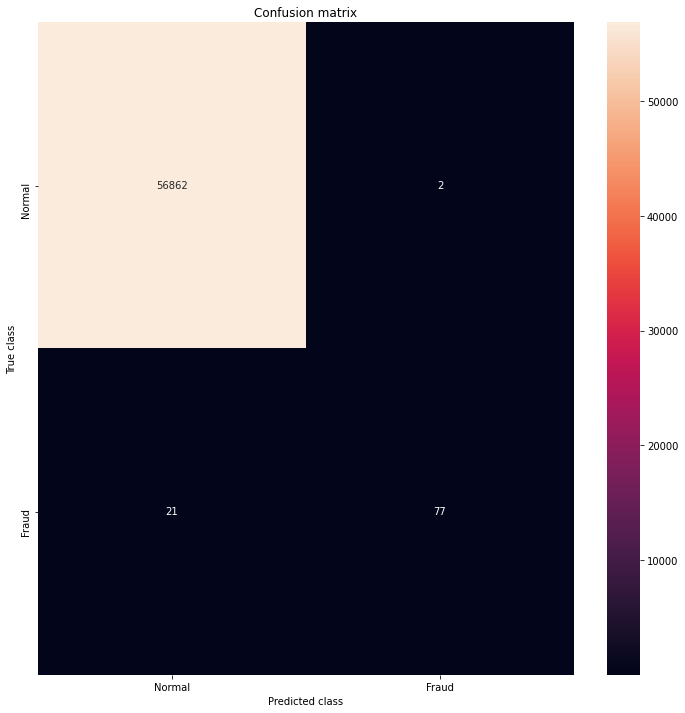

In [31]:
#printing the confusion matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [32]:
# Run classification metrics
plt.figure(figsize=(9, 7))
print('{}: {}'.format("Isolation Forest", n_errors))
print(accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, y_pred))

Isolation Forest: 23
0.9995962220427653
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.79      0.87        98

    accuracy                           1.00     56962
   macro avg       0.99      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962



<Figure size 648x504 with 0 Axes>

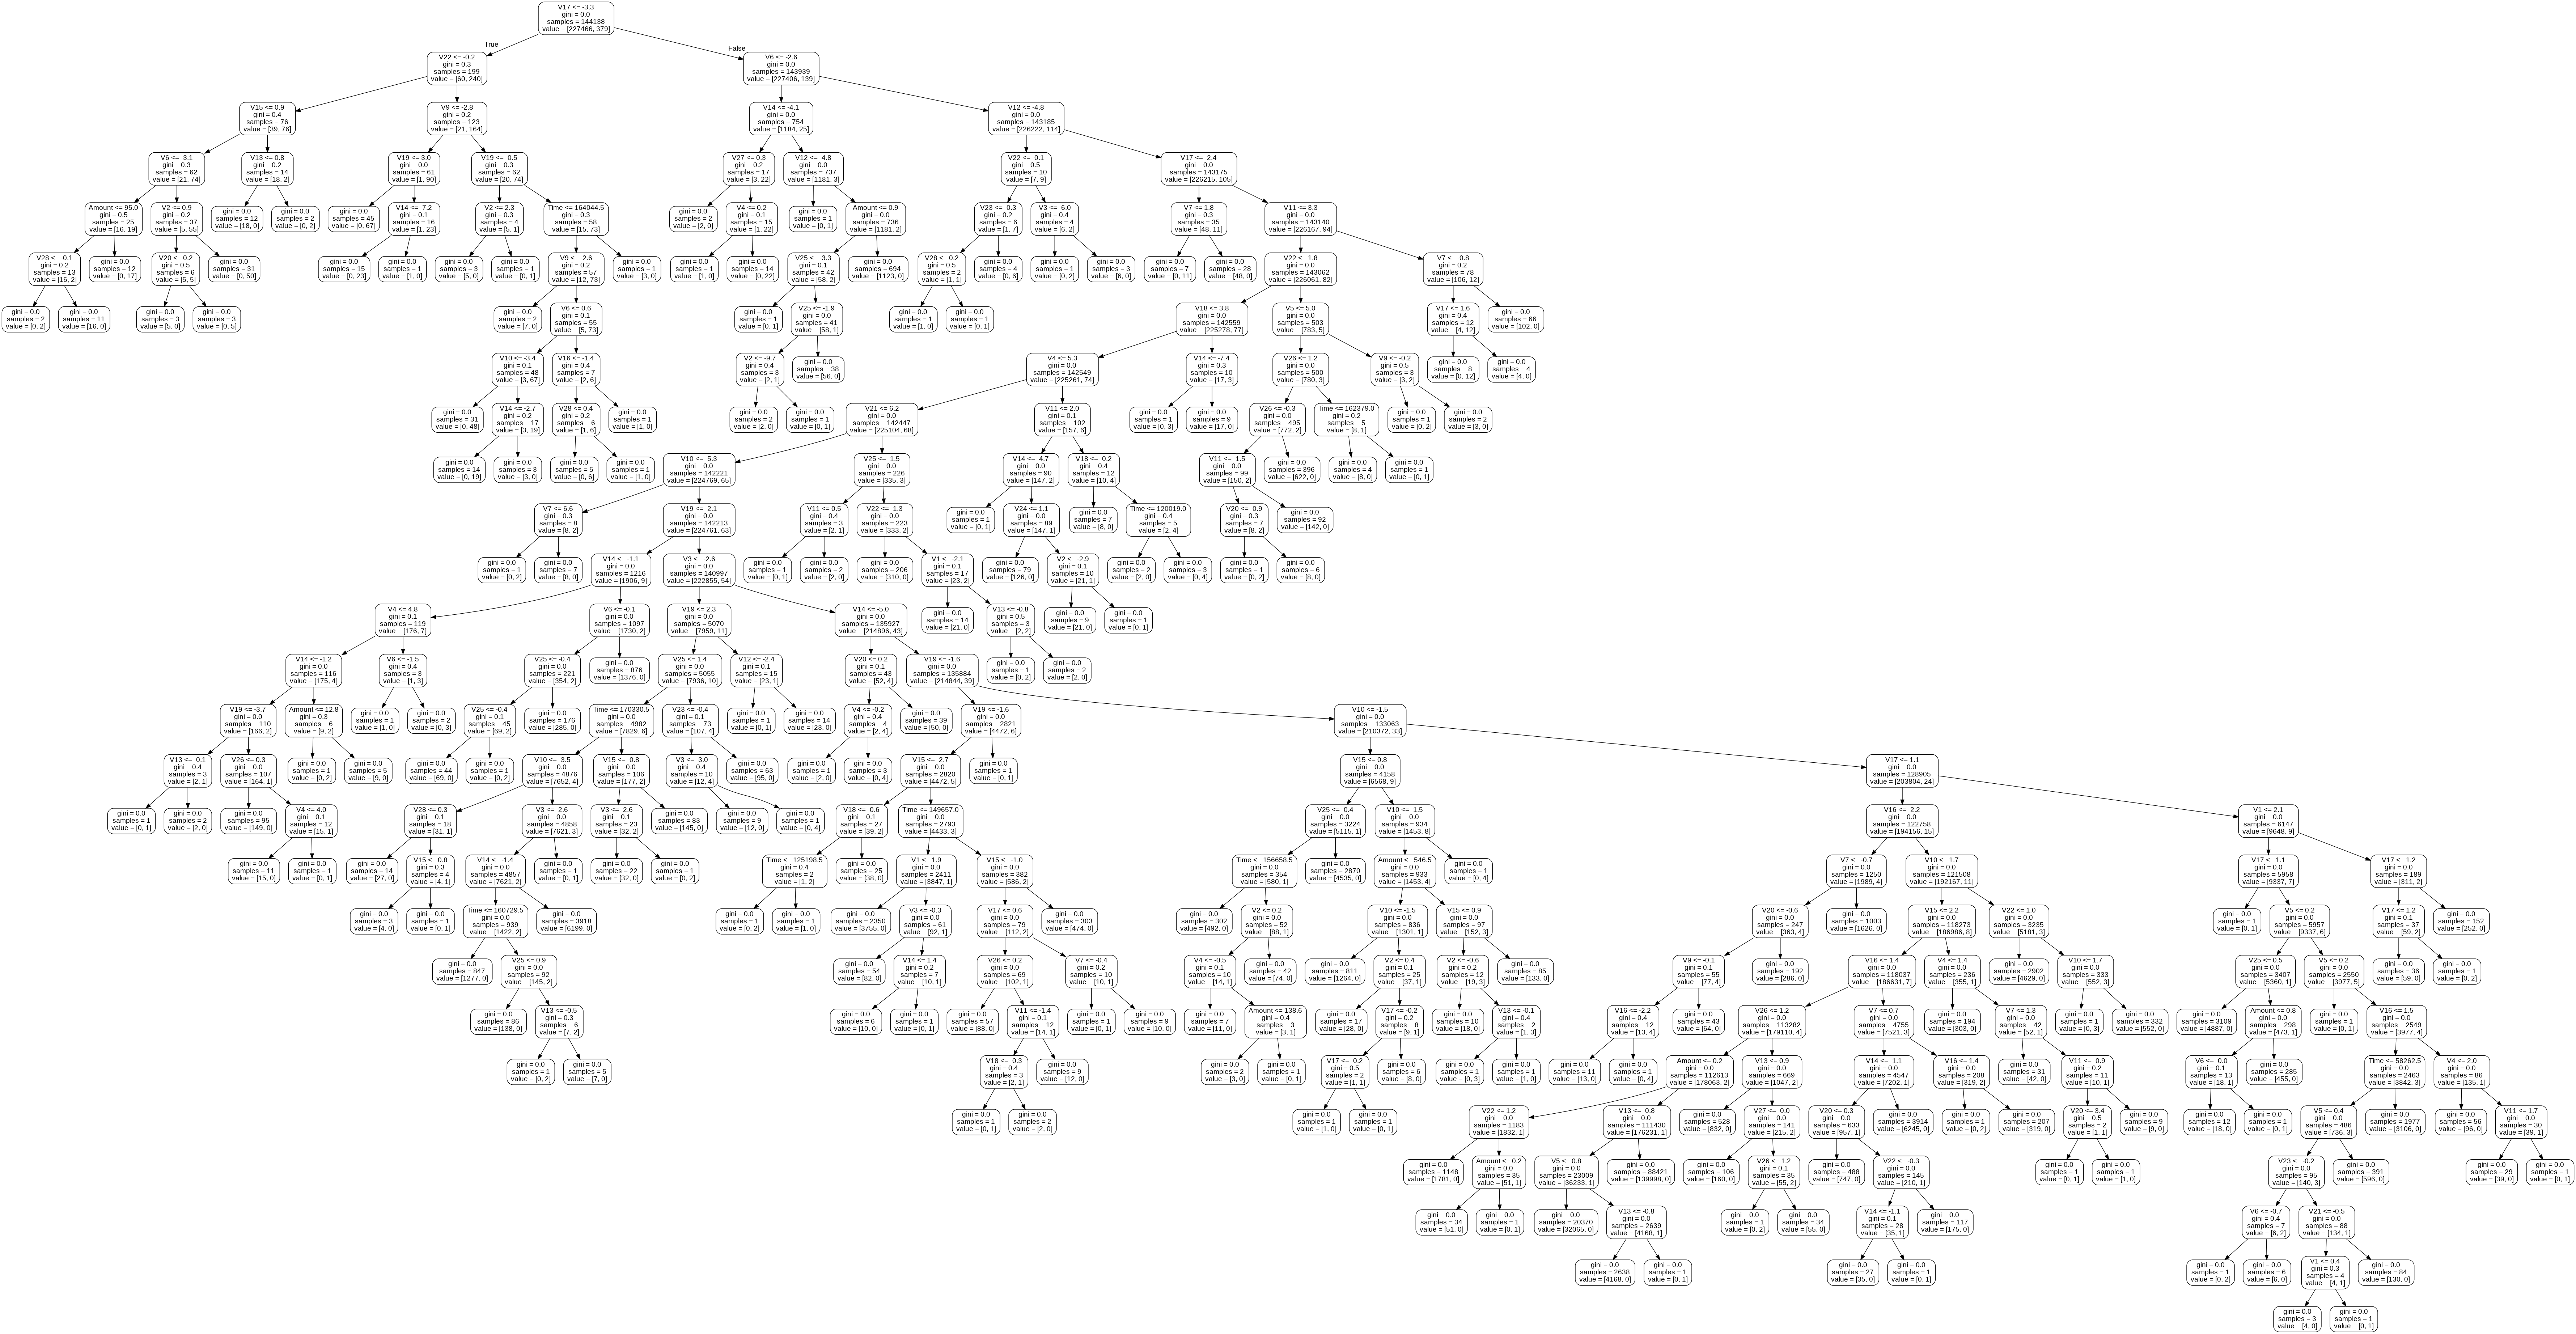

In [33]:
#visualizing the random tree 
feature_list = list(X.columns)
# Import tools needed for visualization
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydot

#pulling out one tree from the forest
tree = rfc.estimators_[5]
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
display(Image(graph.create_png()))